<font color='green'>Пример BERT с GPU:
```python
%%time
from tqdm import notebook
batch_size = 2 # для примера возьмем такой батч, где будет всего две строки датасета
embeddings = [] 
for i in notebook.tqdm(range(input_ids.shape[0] // batch_size)):
        batch = torch.LongTensor(input_ids[batch_size*i:batch_size*(i+1)]).cuda() # закидываем тензор на GPU
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()
        
        with torch.no_grad():
            model.cuda()
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy()) # перевод обратно на проц, чтобы в нумпай кинуть
        del batch
        del attention_mask_batch
        del batch_embeddings
        
features = np.concatenate(embeddings) 
```
Можно сделать предварительную проверку на наличие GPU.\
Например, так: ```device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")```\
Тогда вместо .cuda() нужно писать .to(device)


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорты-модулей-и-билиотек" data-toc-modified-id="Импорты-модулей-и-билиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорты модулей и билиотек</a></span></li><li><span><a href="#Изучение-исходных-данных" data-toc-modified-id="Изучение-исходных-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Изучение исходных данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Выбор-моделей-для-обучения-и-метрики" data-toc-modified-id="Выбор-моделей-для-обучения-и-метрики-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Выбор моделей для обучения и метрики</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#Предсказание-на-тестовых-данных" data-toc-modified-id="Предсказание-на-тестовых-данных-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Предсказание на тестовых данных</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорты модулей и билиотек

In [1]:
import re

from catboost import CatBoostClassifier
import nltk
from nltk.corpus import stopwords as nltk_stopwords  # для себя выделяю именно стоп слова из библиотеки
from nltk.stem import WordNetLemmatizer 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

### Изучение исходных данных

Откроем файл и загрузим данные.

In [2]:
path = '/datasets/toxic_comments.csv'
try:
    # Пробуем открыть файл локально, если нет, то через сервер яндекса.
    data = pd.read_csv(path, decimal=",", engine='python')
except Exception:
    print('Локальный файл не найден. Пробую открыть серверную версию файла.')
    data = pd.read_csv(f'нет ссылки{path}', decimal=",")

data.head(10)

Локальный файл не найден. Пробую открыть серверную версию файла.


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


В данных появился столбец "Unnamed: 0", который судя по всему дублирует индексы. Избавимся от него.

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


В данных 159292 строк. Есть капс, множество разных символов, в том числе и переносы строк. Будет необходимо очистить данные от этого. Проверим так же распределение целевого признака.

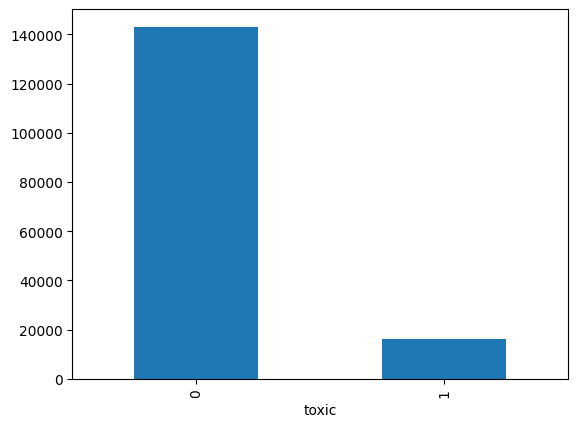

In [5]:
data['toxic'].value_counts().plot(kind='bar');

Очевидно, что есть явных дисбаланс по классам для целевого признака.

**Вывод:** в данных присутствуют символы, пропущенных значений предварительно нет, наблюдается дисбаланс целевого признака.

### Предобработка данных

In [6]:
def clearing_the_text(text: str) -> str:
    """Функция для очистки текста от символов, переносов и т.п. по регулярке [^a-zA-Z ]."""
    re_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return ' '.join(re_text.split())

def lemmatization_of_the_text(text: str) -> str:
    """Инициализируем Wordnet Lemmatizer, прогоняем его по тексту и возвращаем текст в виде строки."""
    lemm = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    return " ".join([lemm.lemmatize(word) for word in word_list])



<div class="alert alert-block alert-info">
    
<b>Совет:</b> 
    
-  Для более корректной работы  WordNetLemmatizer, вместо со словом, желательно передавать его POS-тег (part of speech). https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/
    
	

-  Если  процесс лемматизации затягивается, можно попробовать [.parallel_apply](https://pypi.org/project/pandarallel/),  кому-то это помогает уменьшить время прогона кода раз в 5-7. А у большинства он вообще не запускается ) Предварительно:



    from pandarallel import pandarallel
    tqdm.pandas(desc="progress")
    pandarallel.initialize(progress_bar = True)




</div>


Для начала очистим текст от символов и приведем к единому регистру.

In [7]:
data['text'] = data['text'].str.lower()

Хм...а вот интересно, есть ли большая разница в приведении текста в нижнему регистру или верхнему?



<div class="alert alert-block alert-success">
<b>Ответ:</b> Учитывая, что мы будем обучать векторайзер самостоятельно - то разницы быть не должно.
</div>

Далее очистим текст от символов при помощу регулярок.

In [8]:
data['text'] = data['text'].apply(clearing_the_text)

Ну и всё. Ой, а еще же лемматизация...Блин, а в теории только про русский текст, но задание дали на инглише. Изи-бризи - подключаем модуль гугл-переводчика, переводим весь текст и работаем дальше как по теории. Да ладно, шучу. Это была бы лютая дичь, но стоило бы в курсе хотя бы отметить, что лучше использовать для проекта. Гуглим - `Wordnet`, `Lemmatizer`, `Spacy Lemmatizer`, `TextBlob`, `CLiPS Pattern`, `Stanford CoreNLP`, `Gensim Lemmatizer`, `TreeTagger`. Что лучше использовать? К чему привычнее ревьювер и что было бы предпочтительнее? Какие плюсы/минусы у каждого? В общем, класс. По ходу уже практики разберусь. Если вам доводилось использовать эти библиотеки, то было бы интересно услышать с какими проблемами вы сталкивались и к какой в итоге решили пользоваться. Я возьму просто первую по ссылке `Wordnet`. На всякий случай оставлю ссылку на сайт(на самом деле для портфолио, потом этот текст поправлю, уберу явные ссылки на данные и отправлю на гит), где взял это: https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/



<div class="alert alert-block alert-success">
<b>Ответ:</b> Я в своей практике пользовался в основном WordNet и Spacy. Spacy предоставляет более гибкий и мощный подход к лемматизации, основанный на машинном обучении и контексте, в то время как WordNetLemmatizer предоставляет простой и надежный метод, основанный на лексической базе данных WordNet. И хочу сказать, если для WordNet использовать POS-теги, а для второго выбрать тяжелую модель (например large), то качество будет соизмеримым - поэтому не вижу смысла сильно насчет подхода заморачиваться, что удобнее - то и юзай)

</div>

In [9]:
%%time

nltk.download('punkt')
nltk.download('wordnet')
data['text'] = data['text'].apply(lemmatization_of_the_text)

[nltk_data] Downloading package punkt to /home/dwpsd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dwpsd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


CPU times: user 59.9 s, sys: 49.4 ms, total: 59.9 s
Wall time: 1min


Предполагаю, что после ламматизации мы можем получить строки, которые будут дублировать друг друга, раз приводим в один формат и тому подобное. Поэтому проверим количество дубликатов.

In [10]:
print("Количество дубликатов до удаления:", data.duplicated().sum())
data.drop_duplicates(inplace=True)
print("Количество дубликатов после удаления:", data.duplicated().sum())

Количество дубликатов до удаления: 1307
Количество дубликатов после удаления: 0


~~О, теория с дубликатами не подтвердилась~~. Значит я правильно понял, что столбец "Unnamed: 0" просто дубль индексов. Просто странно, что в таком количестве строк не было дублей. Ведь недавно всеми любимое "я твою мамку в кино водил" обычно бывает в комментах не один раз :) Помимо этого я на всякий случай вручную проверил. Примерно на 6480 пропало порядка 5 строк. Но вряд ли стоит оставлять этот столбец из-за этого. Посмотрим как выглядят первые 10 строк подготовленного и обработанного текста.


<div class="alert alert-block alert-info">
    
<b>Совет:</b> Неплохо было бы вывести результаты до/после лемматизации и очистки, чтобы видеть как у нас видоизменяется текст. Заодно некая проверка корректности написанных функций

In [11]:
data.head(10)

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestion on impro...,0
4,you sir are my hero any chance you remember wh...,0
5,congratulation from me a well use the tool wel...,0
6,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article...,0
8,sorry if the word nonsense wa offensive to you...,0
9,alignment on this subject and which are contra...,0


**Вывод:**    
* изучили исходные данные;
* избавились от лишних символов(\n, @ и прочего);
* лемматизировали текст;
* избавились от дубликатов текста.

## Обучение

### Подготовка данных

In [12]:
RANDOM_STATE = 4221
TEST_SIZE = 0.2

Никаких рекомендаций к разделению выборки не было, поэтому возьмём классику 80/20.

In [13]:
train, test = train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(train.shape, test.shape)

(126388, 2) (31597, 2)


Далее создаём корпусы текстов и переменную для целевого признака.

In [14]:
corpus_train = train['text'].values
corpus_test = test['text'].values

target_train = train['toxic']
target_test = test['toxic']

print(corpus_train.shape, corpus_test.shape)
print(target_train.shape, target_test.shape)

(126388,) (31597,)
(126388,) (31597,)


Оценим важность слов в корпусе. Опять же, а нам нужно это делать? В чем сокральный смысл для модели? Если я правильно понял, то суть в том, что, во-первых, мы исключаем стоп-слова из текста, во-вторых, преобразуем слова в векторы и модель уже работает с числами. Насколько нам важно исключать стоп-слова? Как они влияют на целевой признак? Ведь если они будут в тексте, то скорее всего коммент токсичный. Мы же предсказываем токсичность?! То есть в целом много вопросов в самом задании и без ответа. Вам не нужно мне всё расписывать. В целом понятно. Мы оцениваем какую окраску носит текст. Стоп-слова могут вносить "шум" и мы получим, что текст негативен, хотя он может быть и положительным. И мы по сути не производим оценку важности слов, как это идёт в теории, а строим более корректные векторы этим методом, чтобы модель делала предсказания по векторам слов. 


<div class="alert alert-block alert-info">
    
<b>Ответ:</b>  Исключение стоп-слов позволяет модели сосредоточиться на ключевых словах и фразах. Это помогает повысить качество модели, уменьшая влияние часто встречающихся, но неинформативных слов.
Также положительный эффект оказывается через сокращение размерности признакового пространства и снижения вычислительной сложности модели.
    




- Поэтому здесь вполне уместно провести частотный анализ текста/[облако слов](https://habr.com/ru/post/517410/) - чтобы получить общее представление о тематике и о наиболее часто встречаемых словах в токсичных и нетоксичных твитах Кроме того графики, рисунки делают проект визуально интересней

В тренажере облако импортируем так

    !/opt/conda/bin/python -m pip install wordcloud


или

    !/opt/conda/bin/python -m pip install wordcloud==1.8.2.2


И возможно дополнительно надо будет сделать


    !pip install --upgrade Pillow
</div>


In [15]:
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(min_df=2, stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(corpus_train) 
tf_idf_test = count_tf_idf.transform(corpus_test) 

print("Размер обучающей матрицы:", tf_idf_train.shape)
print("Размер тестовой матрицы:", tf_idf_test.shape)

[nltk_data] Downloading package stopwords to /home/dwpsd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Размер обучающей матрицы: (126388, 56528)
Размер тестовой матрицы: (31597, 56528)


**Вывод:**    
* разбили данные на обучающую и тестовую выборки;
* создали корпусы(набор текстов, в котором эмоции и ключевые слова уже размечены);
* векторизировали текст для дальнейшего обучения моделей.

 ### Выбор моделей для обучения и метрики

В задании нам нужно обучить модель, а в алгоритме задания "обучить разные модели". Видимо, кто-то не до конца определился. Я запутался, поэтому выберу три модели для обучения - регресиию(как классическую), лес, ну и кошечку от яндекса:    
* LogisticRegression;
* RandomForestClassifier;
* CatBoostClassifier.

По заданию метрика качества это F1 не меньше 0.75. Это совместная метрика для оценки качества алгоритма классификации, которая учитывает обе метрики Precision (точность) и Recall (полнота).

F1-score является гармоническим средним между Precision и Recall, что делает эту метрику более сбалансированной, чем каждая из них по отдельности. F1-score особенно полезна в случаях, когда классы в данных несбалансированы или когда ошибки первого и второго рода имеют схожую важность.

Поскольку у нас классы несбалансированны логично использовать именно её.

### LogisticRegression

In [16]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('lr', LogisticRegression())])
hyperparameters = {
    'tfidf__min_df': range(1, 3),
    'lr__C': [1, 10],
    'lr__solver': ['liblinear', 'newton-cg', 'saga']
}

rs_grid_lr = RandomizedSearchCV(
    pipe,
    param_distributions=hyperparameters,
    scoring='f1') 
rs_grid_lr.fit(corpus_train, target_train)

f1_train_lr = round(abs(rs_grid_lr.best_score_), 2)

print(f"Значение F1 модели на обучающих данных для LogisticRegression: {f1_train_lr}")
print(f"Оптимальные гиперпараметры для модели LogisticRegression: {rs_grid_lr.best_params_}")

Значение F1 модели на обучающих данных для LogisticRegression: 0.77
Оптимальные гиперпараметры для модели LogisticRegression: {'tfidf__min_df': 2, 'lr__solver': 'liblinear', 'lr__C': 10}
CPU times: user 6min 38s, sys: 51.4 s, total: 7min 29s
Wall time: 5min 30s


**Вывод:**    
* Метрика F1 для модели логистической регрессии отвечает требованиям заказчика;
* обучение проводится довольно долго и с тремя гиперпараметрами для solver составляет порядка 14 минут.


### RandomForestClassifier

In [17]:
%%time

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('rfc', RandomForestClassifier(random_state=RANDOM_STATE))
])
hyperparameters = {
    'tfidf__min_df': range(1, 3),
    'rfc__n_estimators': [2, 10]
}

rs_grid_rfc = RandomizedSearchCV(
    pipe,
    param_distributions=hyperparameters,
    scoring='f1',
    n_jobs=-1) 
rs_grid_rfc.fit(corpus_train, target_train) 

f1_train_rfc = round(abs(rs_grid_rfc.best_score_), 2)

print(f"Значение F1 модели на обучающих данных для RandomForestClassifier: {f1_train_rfc}")
print(f"Оптимальные гиперпараметры для модели RandomForestClassifier: {rs_grid_rfc.best_params_}")

# Wall time: 4min 29s

/home/dwpsd/Dev/ds_practicum_projects/venv/lib64/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Значение F1 модели на обучающих данных для RandomForestClassifier: 0.69
Оптимальные гиперпараметры для модели RandomForestClassifier: {'tfidf__min_df': 2, 'rfc__n_estimators': 10}
CPU times: user 38.6 s, sys: 1.09 s, total: 39.7 s
Wall time: 3min 36s


**Вывод:**    
* метрика F1 для модели леса не соотвествует требованиям заказчика;
* в целом обучение модели проходило быстрее чем для логистической регресии.

### CatBoostClassifier

In [18]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
                 ('cbc', CatBoostClassifier(random_state=RANDOM_STATE, verbose=10))])
hyperparameters = {
    'tfidf__min_df': range(1, 3),
    'cbc__iterations': [10, 20]
}

rs_grid_cat = RandomizedSearchCV(
    pipe,
    param_distributions=hyperparameters,
    scoring='f1',
    n_jobs=-1) 
rs_grid_cat.fit(corpus_train, target_train) 

f1_train_cat = round(abs(rs_grid_cat.best_score_), 2)

print(f"Значение F1 модели на обучающих данных для CatBoostClassifier: {f1_train_cat}")
print(f"Оптимальные гиперпараметры для модели CatBoostClassifier: {rs_grid_cat.best_params_}")

/home/dwpsd/Dev/ds_practicum_projects/venv/lib64/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Learning rate set to 0.5
0:	learn: 0.3323972	total: 2.75s	remaining: 24.7s
9:	learn: 0.1866211	total: 21.2s	remaining: 0us


/home/dwpsd/Dev/ds_practicum_projects/venv/lib64/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Learning rate set to 0.5
0:	learn: 0.3336652	total: 2.37s	remaining: 21.3s
9:	learn: 0.1851786	total: 22.6s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3306190	total: 2.17s	remaining: 19.5s
9:	learn: 0.1842930	total: 21.6s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3430929	total: 2.82s	remaining: 25.4s
9:	learn: 0.1853300	total: 22.1s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3442309	total: 2.91s	remaining: 26.2s
9:	learn: 0.1878299	total: 14.2s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3323972	total: 1.96s	remaining: 37.1s
10:	learn: 0.1840232	total: 23.1s	remaining: 18.9s
19:	learn: 0.1643159	total: 38.7s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3452321	total: 2.23s	remaining: 20.1s
9:	learn: 0.1891228	total: 19.5s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3399165	total: 1.74s	remaining: 15.6s
9:	learn: 0.1863391	total: 16.3s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3306190	total: 1.94s	remaining: 36.8s
10:	learn: 0

**Вывод:**    
* метрика F1 для модели котика не соотвествует требованиям заказчика;
* в целом обучение модели проходило чуть быстрее чем для регресии.

### Предсказание на тестовых данных

Лучшей моделью по характеристике F1 оказалась логистическая регрессия. Предскажем тестовые данные на ней.

In [19]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('lr', LogisticRegression())])
pipe.set_params(**rs_grid_lr.best_params_)
pipe.fit(corpus_train, target_train)

target_predict = pipe.predict(corpus_test)
f1_test = round(f1_score(target_test, target_predict), 3)
print(f"F1 модели на тесте: {f1_test}")

F1 модели на тесте: 0.77
CPU times: user 11.4 s, sys: 36.5 ms, total: 11.4 s
Wall time: 6.83 s
Learning rate set to 0.5
0:	learn: 0.3373555	total: 2.41s	remaining: 45.8s
10:	learn: 0.1820157	total: 16.8s	remaining: 13.8s
19:	learn: 0.1615774	total: 28.1s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3444373	total: 1.48s	remaining: 28.1s
10:	learn: 0.1840535	total: 16.6s	remaining: 13.6s
19:	learn: 0.1633344	total: 32.1s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3399165	total: 967ms	remaining: 18.4s
10:	learn: 0.1838738	total: 10.6s	remaining: 8.66s
19:	learn: 0.1615651	total: 19.2s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3536625	total: 1.11s	remaining: 21s
10:	learn: 0.1814997	total: 11s	remaining: 8.97s
19:	learn: 0.1624286	total: 19.4s	remaining: 0us


**Вывод:**    
Модель логистической регрессии соответствует требованиям заказчика пометрике F1. Остальные модели не соответствуют требованиям. Возможно, если увеличить значения гиперпараметров, то получится увеличить качество на бустинге. Так же можно было бы попробовать сбалансировать данные, но всё это может как значительно увеличить время на обучение моделей, так и оказаться безрезультатным.

## Выводы

* были обучены три модели LogisticRegression, RandomForestClassifier, CatBoostClassifier;
* требованиям заказчика по метрике F1 отвечает только модель LogisticRegression;
* вероятно, низкие значения метрик на других моделях вызваны дисбалансом классов.



<div class="alert alert-block alert-info">
    
<b>Совет: </b> Почему бы дисбаланс не учесть? интересная и полезная статья на эту тему: https://dyakonov.org/2021/05/27/imbalance/